In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cmocean
import warnings

In [2]:
NAME = 'T100'
LONGNAME = '100 hPa temperature'
MONTHS_NH = [6,7,8,9,10]  # NH TC season months [1: Jan - 12: Dec]
MONTHS_SH = [1,2,3,4,5]   # SH TC season months

In [3]:
TROP_P = xr.open_dataset('../jobs/TROP_P/data/TROP_P.nc').TROP_P

In [4]:
ds = xr.open_dataset(f'../jobs/{NAME}/data/{NAME}.nc')
ds = ds.squeeze()
ds['TROP_P'] = TROP_P/100

# add anomalies to datasets
for exp in ['cnt-ref','sai-ref','sai-cnt']:
    exp1,exp2 = exp.split('-')
    diff = ds.sel(exp=exp1) - ds.sel(exp=exp2)
    diff = diff.assign_coords(exp=exp)
    ds = xr.concat((ds,diff), dim='exp')

# add month weights and gaussian latitude weights
ds['dpm'] = ('month', [31,28,31,30,31,30,31,31,30,31,30,31])
with xr.open_dataset('../data/gw.nc').gw as gw:
    ds['gw'] = gw

# add 2D latitude and longitude for plotting
ds['lat2d'], ds['lon2d'] = xr.broadcast(ds.lat, ds.lon)
ds = ds.set_coords(['lat2d', 'lon2d'])

# AVERAGE TO 0.5 DEG RES
#ds = ds.coarsen(lat=2, lon=2).mean()

# print annual mean quantile information for plotting limits
data = ds[NAME].weighted(ds.dpm).mean('month')
print('exp','[min, 0.02 pct, 0.98 pct, max]')
for exp in data.exp.data:
    print(exp, data.sel(exp=exp).quantile([0,0.02,0.98,1]).data)

exp [min, 0.02 pct, 0.98 pct, max]
ref [189.68452211 190.22321845 219.45113308 220.66756295]
cnt [192.92238339 193.35725882 219.74785122 221.4448549 ]
sai [192.28744628 192.88819577 223.02791964 225.5499684 ]
cnt-ref [-2.36454911 -2.07780921  3.16379109  3.40229605]
sai-ref [-2.94784767 -2.8529497   5.87417414  6.86120664]
sai-cnt [-1.16545226 -1.09112048  4.39356025  5.27852846]


In [5]:
cfkwargs_abs = dict(levels=np.arange(185,226,5), vmin=185, vmax=225, extend='neither', cmap='cmo.thermal', transform=ccrs.PlateCarree(), transform_first=True)
cfkwargs_rel = dict(levels=np.arange(-7,7.1,1), vmin=-8, vmax=8, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree(), transform_first=True)
cbarunit_abs = 'K'
cbarunit_rel = 'K'

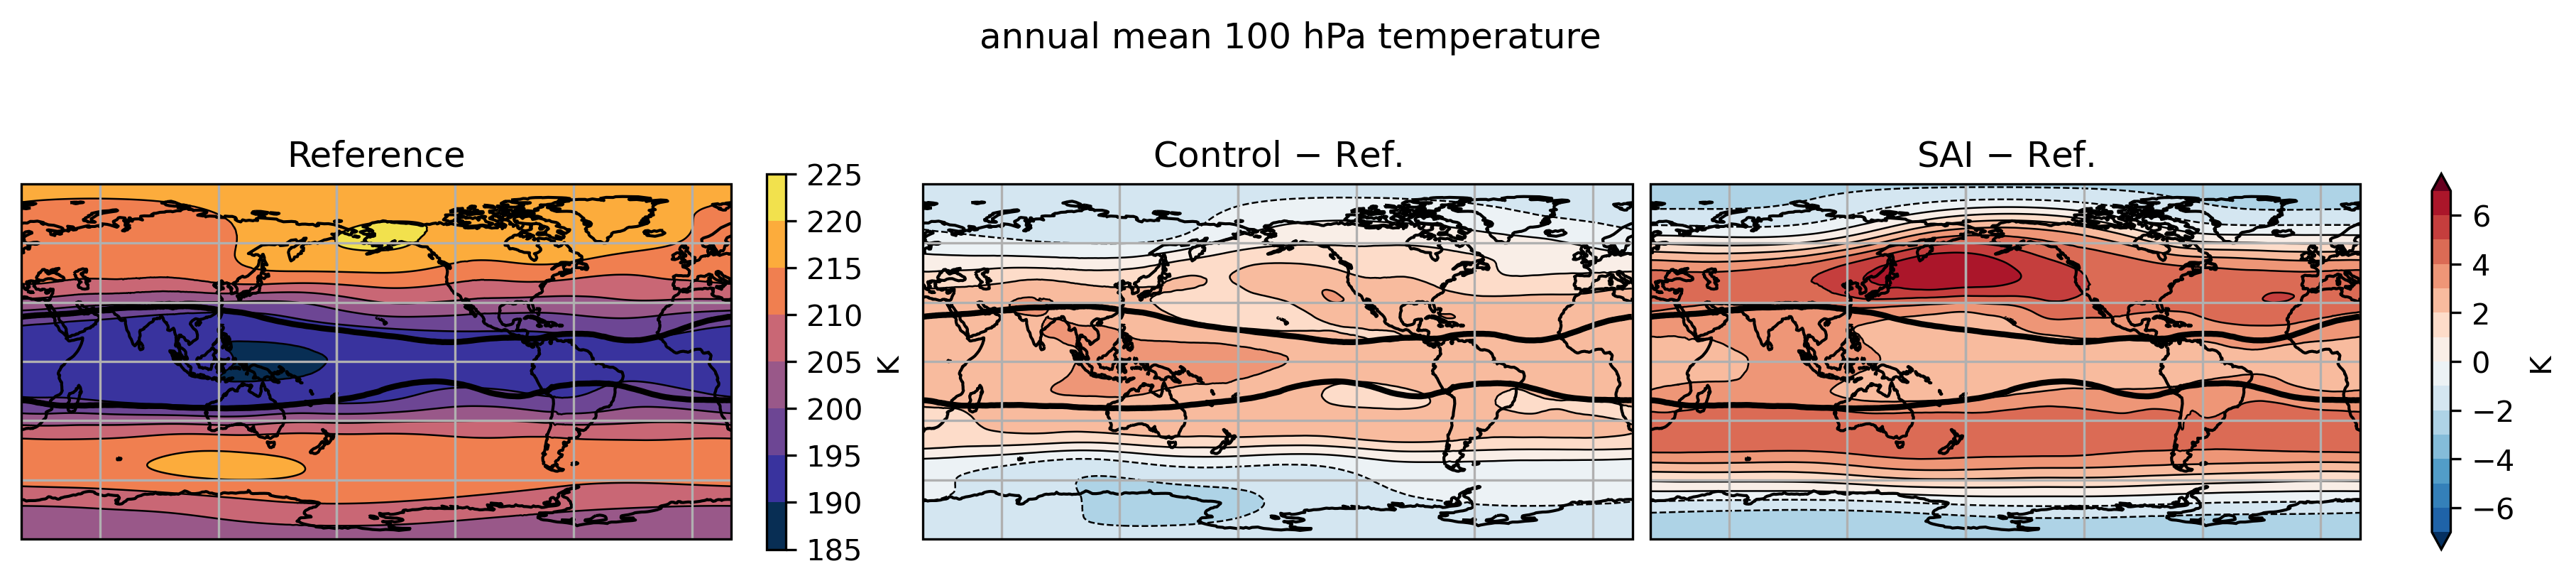

In [6]:
data = ds[NAME].weighted(ds.dpm).mean('month')
data_trop = ds.TROP_P.weighted(ds.dpm).mean('month')

kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax=axs[0]
pcm = ax.contourf(data.lon2d, data.lat2d, data.sel(exp='ref'), **cfkwargs_abs)
psm = ax.contour(data.lon2d, data.lat2d, data.sel(exp='ref'), levels=pcm.levels, colors='k', linewidths=0.6, **kwargs)
ptm = ax.contour(data_trop.lon2d, data_trop.lat2d, data_trop.sel(exp='ref'), levels=[100], linewidths=[2], colors='k', **kwargs)
#pcm.set_rasterized(True)
#psm.set_rasterized(True)
#ax.contour(data.lon2d, data.lat2d, data.sel(exp='ref'), levels=[25], colors='k', linewidths=1.2, linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel(cbarunit_abs)
ax.set_title('Reference')

for ax,exp,tit in zip(axs[1:],['cnt-ref','sai-ref'],['Control $-$ Ref.','SAI $-$ Ref.']):
    pcm = ax.contourf(data.lon2d, data.lat2d, data.sel(exp=exp), **cfkwargs_rel)
    psm = ax.contour(data.lon2d, data.lat2d, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=[0.6], **kwargs)
    ptm = ax.contour(data_trop.lon2d, data_trop.lat2d, data_trop.sel(exp='ref'), levels=[100], linewidths=[2], colors='k', **kwargs)
    #pcm.set_rasterized(True)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel(cbarunit_rel)

for ax in axs.flatten():
    ax.gridlines()
    ax.coastlines()

fig.suptitle('annual mean '+LONGNAME, y=0.9)
fig.savefig(f'../figures/{NAME}.annualmean.pdf', bbox_inches='tight', transparent=True)

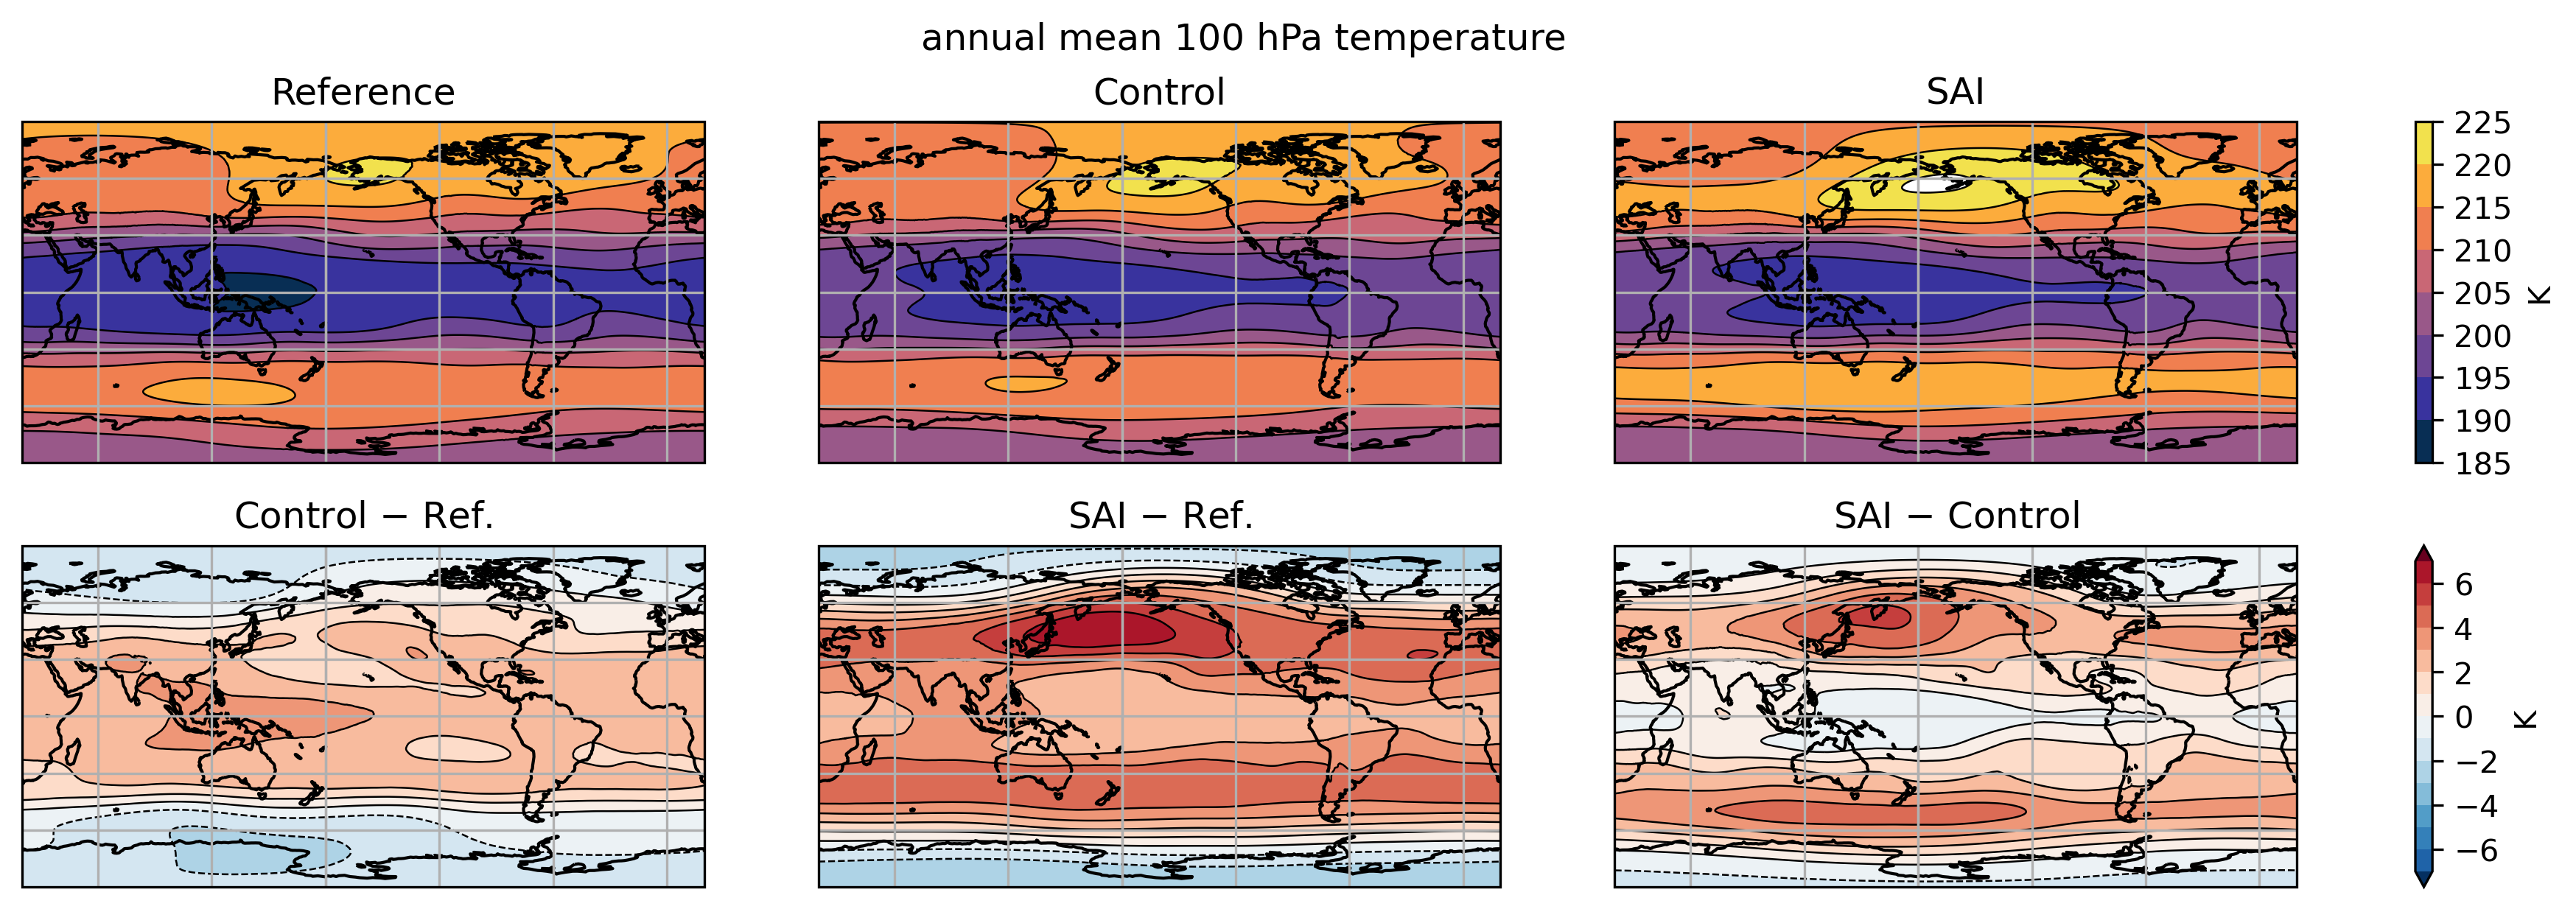

In [7]:
data = ds[NAME].weighted(ds.dpm).mean('month')

kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

fig,axs = plt.subplots(2,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

# top row: ref, cnt, sai
for ax,exp,tit in zip(axs[0,:], ['ref','cnt','sai'],['Reference','Control','SAI']):
    pcm = ax.contourf(data.lon2d, data.lat2d, data.sel(exp=exp), **cfkwargs_abs)
    psm = ax.contour(data.lon2d, data.lat2d, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=0.6, **kwargs)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[0,:], orientation='vertical')
cb.ax.set_ylabel(cbarunit_abs)

# bottom row: differences
for ax,exp,tit in zip(axs[1,:],['cnt-ref','sai-ref','sai-cnt'],['Control $-$ Ref.','SAI $-$ Ref.','SAI $-$ Control']):
    pcm = ax.contourf(data.lon2d, data.lat2d, data.sel(exp=exp), **cfkwargs_rel)
    psm = ax.contour(data.lon2d, data.lat2d, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=[0.6], **kwargs)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[1,:], orientation='vertical')
cb.ax.set_ylabel(cbarunit_rel)

for ax in axs.flatten():
    ax.gridlines()
    ax.coastlines()

fig.suptitle('annual mean '+LONGNAME)
fig.savefig(f'../figures/{NAME}.annualmean.full.pdf', bbox_inches='tight', transparent=True)

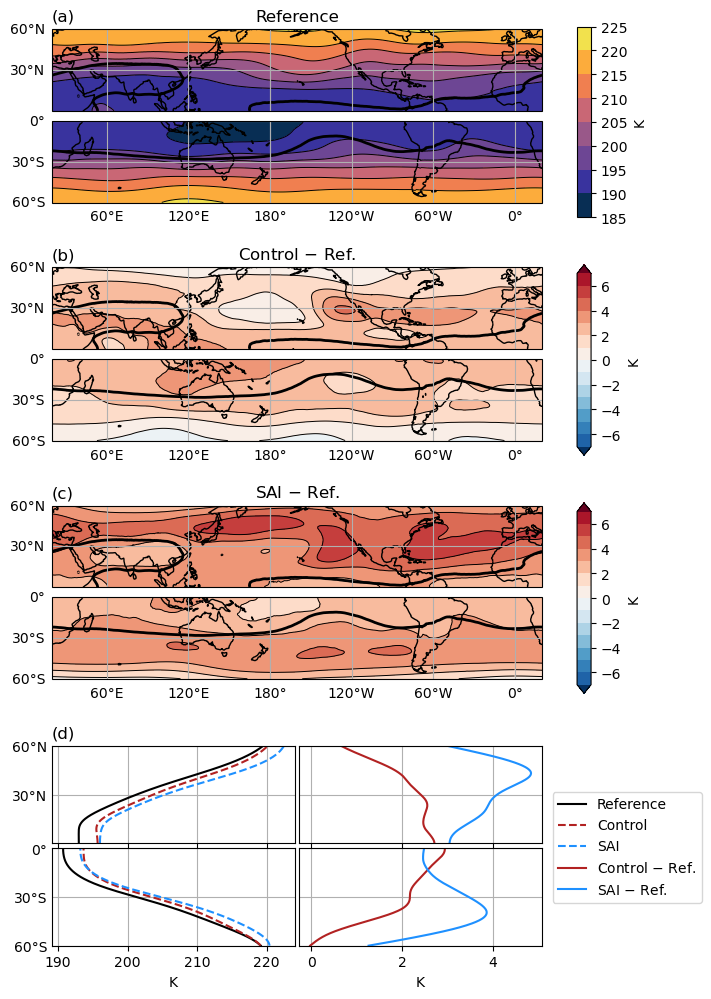

In [8]:
data_NH = ds[NAME].sel(month=MONTHS_NH, lat=slice(0,60)).weighted(ds.dpm).mean('month')
data_SH = ds[NAME].sel(month=MONTHS_SH, lat=slice(-60,0)).weighted(ds.dpm).mean('month')
datatrop_NH = ds.TROP_P.sel(month=MONTHS_NH, lat=slice(0,60)).weighted(ds.dpm).mean('month')
datatrop_SH = ds.TROP_P.sel(month=MONTHS_SH, lat=slice(-60,0)).weighted(ds.dpm).mean('month')

cfdata = {
    'a': [data_NH.sel(exp='ref'), data_SH.sel(exp='ref')],
    'b': [data_NH.sel(exp='cnt-ref'), data_SH.sel(exp='cnt-ref')],
    'c': [data_NH.sel(exp='sai-ref'), data_SH.sel(exp='sai-ref')],
}

cfkwargs = {'a': cfkwargs_abs, 'b': cfkwargs_rel, 'c': cfkwargs_rel}
cbkwargs = {'a': dict(label=cbarunit_abs), 'b': dict(label=cbarunit_rel), 'c': dict(label=cbarunit_rel)}
supy = {'a': 'Reference', 'b': 'Control $-$ Ref.', 'c': 'SAI $-$ Ref.'}

fig = plt.figure(figsize=(7, 10))
subfigs = fig.subfigures(2, 1, hspace=0.0, height_ratios=[3, 1.2])
mapfigs = subfigs[0].subfigures(3,1,hspace=0, wspace=0)
zmfig = subfigs[1]#.subfigures(1,1,wspace=0)

for i,mfig, in zip('abc', mapfigs.flatten()):
    axt, axb = mfig.subplots(2,1, sharex=True, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})
    cft = axt.contourf(cfdata[i][0].lon2d, cfdata[i][0].lat2d, cfdata[i][0], **cfkwargs[i])
    cfb = axb.contourf(cfdata[i][1].lon2d, cfdata[i][1].lat2d, cfdata[i][1], **cfkwargs[i])
    cst = axt.contour(cfdata[i][0].lon2d, cfdata[i][0].lat2d, cfdata[i][0], levels=cft.levels, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())
    csb = axb.contour(cfdata[i][1].lon2d, cfdata[i][1].lat2d, cfdata[i][1], levels=cfb.levels, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())
    ctt = axt.contour(datatrop_NH.lon2d, datatrop_NH.lat2d, datatrop_NH.sel(exp='ref'), levels=[100], colors='k', linewidths=2, transform=ccrs.PlateCarree())
    ctb = axb.contour(datatrop_SH.lon2d, datatrop_SH.lat2d, datatrop_SH.sel(exp='ref'), levels=[100], colors='k', linewidths=2, transform=ccrs.PlateCarree())
    for ax in (axt, axb):
        ax.coastlines()
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
    axt.gridlines(ylocs=[0, 30, 60], draw_labels=['left'])
    axb.gridlines(ylocs=[0,-30,-60], draw_labels=['left','bottom'])
    axt.set_extent((20,380,0,60.0001), crs=ccrs.PlateCarree())
    axb.set_extent((20,380,-60.001,0.001), crs=ccrs.PlateCarree())
    mfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.15, hspace=0.05)
    cbtax = mfig.add_axes((0.875,0.1,0.02,0.8))
    mfig.colorbar(cft, cax=cbtax, **cbkwargs[i])
    axt.set_title(f'({i})', loc='left')
    axt.set_title(supy[i])

axs = zmfig.subplots(2,2, sharey='row', sharex='col')
zmfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.2, wspace=0.05/3)
for ax in axs[0,:]:
    ax.set_ylim([0,60])
    ax.yaxis.set_tick_params(length=0)
for ax in axs[1,:]:
    ax.set_ylim([-60,0])
    ax.yaxis.set_tick_params(length=0)
axs[0,0].set_yticks([30,60], labels=['30°N','60°N'])
axs[1,0].set_yticks([-60,-30,0], labels=['60°S','30°S','0°'])

zmfig.axes[0].set_title('(d)', loc='left')
data_NH.sel(exp='ref').mean('lon').plot(ax=zmfig.axes[0], y='lat', c='k', label='Reference')
data_NH.sel(exp='cnt').mean('lon').plot(ax=zmfig.axes[0], y='lat', c='firebrick', ls='--', label='Control')
data_NH.sel(exp='sai').mean('lon').plot(ax=zmfig.axes[0], y='lat', c='dodgerblue', ls='--', label='SAI')

(data_NH.sel(exp='cnt-ref').mean('lon')).plot(ax=zmfig.axes[1], y='lat', c='firebrick', label='Control $-$ Ref.')
(data_NH.sel(exp='sai-ref').mean('lon')).plot(ax=zmfig.axes[1], y='lat', c='dodgerblue', label='SAI $-$ Ref.')

data_SH.sel(exp='ref').mean('lon').plot(ax=zmfig.axes[2], y='lat', c='k', label='Reference')
data_SH.sel(exp='cnt').mean('lon').plot(ax=zmfig.axes[2], y='lat', c='firebrick', ls='--', label='Control')
data_SH.sel(exp='sai').mean('lon').plot(ax=zmfig.axes[2], y='lat', c='dodgerblue', ls='--', label='SAI')

(data_SH.sel(exp='cnt-ref').mean('lon')).plot(ax=zmfig.axes[3], y='lat', c='firebrick', label='Control $-$ Ref.')
(data_SH.sel(exp='sai-ref').mean('lon')).plot(ax=zmfig.axes[3], y='lat', c='dodgerblue', label='SAI $-$ Ref.')

han1, lab1 = zmfig.axes[0].get_legend_handles_labels()
han2, lab2 = zmfig.axes[1].get_legend_handles_labels()
zmfig.legend(han1+han2, lab1+lab2, loc=(0.84,0.35))

zmfig.axes[0].set_xlabel('')
zmfig.axes[1].set_xlabel('')
zmfig.axes[2].set_xlabel(cbarunit_abs)
zmfig.axes[3].set_xlabel(cbarunit_rel)

for ax in zmfig.axes:
    ax.yaxis.set_tick_params(length=0)
    ax.set_title('')
    ax.set_ylabel('')
    ax.grid()

fig.savefig(f'../figures/{NAME}.TCseason.pdf', transparent=True, bbox_inches='tight')

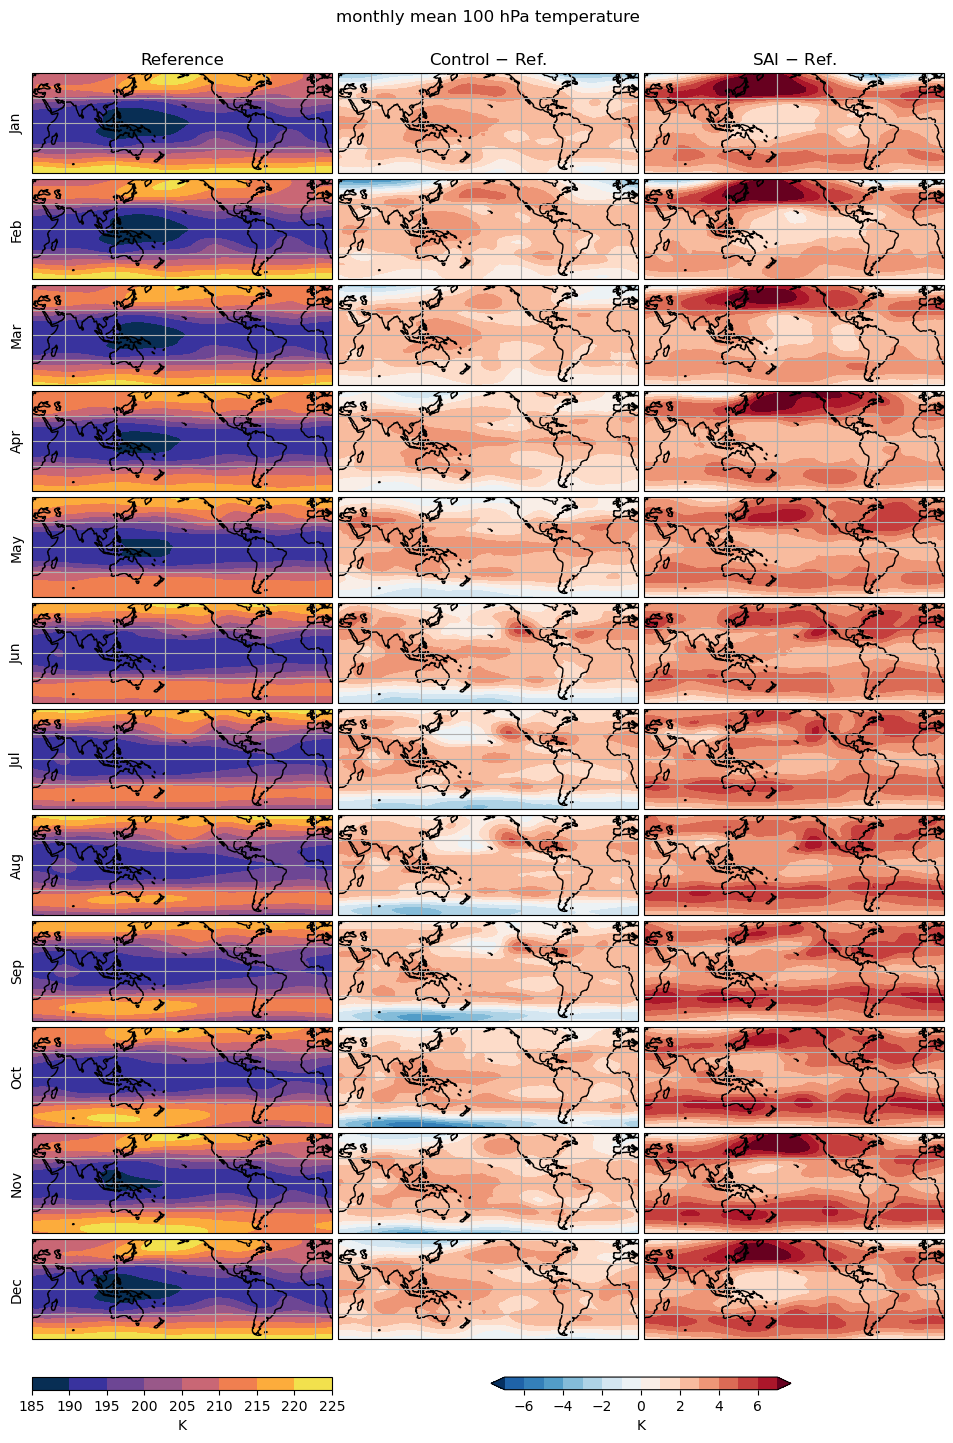

In [9]:
data = ds[NAME].sel(lat=slice(-60,60))

fig, axs = plt.subplots(12, 3, figsize=(9.12,12.66), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

for m,mon in enumerate(data.month):
    for i,exp in enumerate(['ref','cnt-ref','sai-ref']):
        datai = data.sel(exp=exp, month=mon)
        if i > 0:
            cf = axs[m,i].contourf(datai.lon2d, datai.lat2d, datai, **cfkwargs_rel)
            cs = axs[m,i].contour(datai.lon2d, datai.lat2d, data.sel(exp=exp.split('-')[0], month=mon), transform=ccrs.PlateCarree(), levels=[5], colors='k', linewidths=1, linestyles='-')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cf.set_rasterized(True)
                cs.set_rasterized(True)
        else:
            cfr = axs[m,i].contourf(datai.lon2d, datai.lat2d, datai, **cfkwargs_abs)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cfr.set_rasterized(True)
        cs = axs[m,i].contour(datai.lon2d, datai.lat2d, data.sel(exp='ref', month=mon), transform=ccrs.PlateCarree(), levels=[5], colors='k', linewidths=1, linestyles='--')      
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cs.set_rasterized(True)
        cl = axs[m,i].coastlines()
        gl = axs[m,i].gridlines(ylocs=range(-60,61,30), xlocs=range(-180,181,60), crs=ccrs.PlateCarree())
        axs[m,i].set_extent((20,380,-60,60), crs=ccrs.PlateCarree())

for e,exp in enumerate(['ref','cnt-ref','sai-ref']):
    axs[0,e].set_title(['Reference','Control $-$ Ref.','SAI $-$ Ref.'][e])

fig.subplots_adjust(bottom=0, top=1, left=0, right=1,
                    wspace=0.02, hspace=0.06)
cbr_ax = fig.add_axes([0, -0.04, 3/9.12, 0.01])
cb_ax = fig.add_axes([4.59/9.12, -0.04, 3/9.12, 0.01])
cbr = fig.colorbar(cfr, cax=cbr_ax, ticks=None, orientation='horizontal', label=cbarunit_abs)
cb = fig.colorbar(cf, cax=cb_ax, ticks=None, orientation='horizontal', label=cbarunit_rel)
#cbr_ax.axvline(5, c='k', lw=1, ls='--')
#cbr_ax.axvline(5, c='k', lw=1)

for m,ax in enumerate(axs[:,0]):
    bbox = ax.get_position()
    fig.text(bbox.x0-0.05*(bbox.x1-bbox.x0),(bbox.y0+bbox.y1)/2,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][m], ha='center', va='center', rotation=90)

fig.suptitle('monthly mean '+LONGNAME, y=1.05)
fig.savefig(f'../figures/{NAME}.monmean.pdf', dpi=120, transparent=True, bbox_inches='tight')